# Nine-day Continuous Recording of Mouse EEG under Chronic Sleep Restriction (Mouse_EEG_ChronicSleepRestriction_Kim_et_al)

## 1. Publication information


1. Kim, B., Kocsis, B., Hwang, E., Kim, Y., Strecker, R. E., McCarley, R. W., & Choi, J. H. (2017). Differential modulation of global and local neural oscillations in REM sleep by homeostatic sleep regulation. Proceedings of the National Academy of Sciences, 114(9), E1727-E1736 [https://www.pnas.org/content/114/9/E1727].

2. Kim, B., Hwang, E., Strecker, R. E., Choi, J. H., & Kim, Y. (2020). Differential modulation of NREM sleep regulation and EEG topography by chronic sleep restriction in mice. Scientific reports, 10(1), 1-13.




## 2. How to start

download: (g-node url)

Large dataset can be downloaded through gin-cli tool.

After installation gin-cli, run three commands below in your command line window.

 gin get hiobeen/Mouse_EEG_ChronicSleepRestriction_Kim_et_al
 
 cd Mouse_EEG_ChronicSleepRestriction_Kim_et_al/
 
 gin download --content
 
 
Reference: https://gin.g-node.org/G-Node/Info/wiki/GIN+CLI+Usage+Tutorial


## 3. Analysis tutorial

### 3-1) Loading EEG data
This tutorial document includes several examples of EEG data analysis using the dataset of [Mouse_EEG_ChronicSleepRestriction_Kim_et_al]. First, here, we need to import/define some functions that make data handling easier.

In [8]:
""" Define handy functions """
import warnings; warnings.filterwarnings(action='ignore')
import os; from glob import glob
from mne.io import read_raw_eeglab as load 
import numpy as np; import pandas as pd; import pickle
from matplotlib import pyplot as plt; plt.style.use('ggplot')
from matplotlib.pyplot import plot, xlim, ylim, title, xlabel, ylabel, imshow
from scipy.io import loadmat, savemat
from scipy.signal import butter, sosfiltfilt, find_peaks
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
#!pip install scipy==1.1.0
from scipy.misc import imresize as resize
def fft_half(x, fs=500): return np.fft.fft(x.reshape(-1))[:int(len(x)/2)]/len(x), np.linspace(0,fs/2,int(len(x)/2))
def find(x): return np.argwhere( x.flatten() ).flatten()
def find_idx(target_range, continuous_vector):
    start_point = np.where(continuous_vector<target_range[0])[0][-1]+1
    end_point = np.where(continuous_vector<target_range[-1])[0][-1]
    return (start_point, end_point)
def smooth(x, span): return np.convolve(x,np.ones(int(span))/int(span), mode='same')
def interp_nan(x):
    placeholder = np.arange(x.size)
    return np.interp(placeholder, placeholder[np.isfinite(x)], data[np.isfinite(x)])
def bandpower(x, band, fs=500):
  X, freq = fft_half(x,fs)
  return np.mean( abs(X[np.where( (freq > band[0]) & (freq <= band[1]))])**2 )
def find_seg(ind): # Handy function
  ind_diff = np.diff(np.concatenate((np.ones(1)*-1,ind),axis=0))
  discontinuous = np.where(ind_diff!=1)[0]
  if len(discontinuous)>1:
    data_seg = np.zeros((len(discontinuous)-1,2),dtype='int')
    for idx in range(len(discontinuous)-1): data_seg[idx,:]=[ind[discontinuous[idx]],ind[discontinuous[idx+1]-1]]
  else:
    data_seg = np.array([])
  return data_seg
def bandpass_filt(x, band=(8,18), fs=500, order=10):
  #if x.shape[0]>x.shape[1]: x=x.transpose()
  return sosfiltfilt(butter(order,[band[0]/(0.5*fs),band[1]/(0.5*fs)],btype='band',output='sos'),x).reshape(-1)
def get_upper_envelope(y, x, lower_limit = -10000000):
  peaks,_ = find_peaks(y, height=lower_limit)
  peaks_x = np.concatenate((np.array([t[0]]),x[peaks],np.array([t[-1]])), axis=0)
  peaks_y = np.concatenate((np.array([y[0]]),y[peaks],np.array([y[-1]])), axis=0)
  return interp1d(peaks_x, peaks_y, kind = 'cubic')(np.linspace(peaks_x[0], peaks_x[-1], len(y)))


After downloading dataset, you can import EEG dataset using the function load_data(). You need to define the path of dataset on your local machine, in [bids_path] variable. 

In [9]:
# File loading demo
""" Important notice: Change these directories to fit your local environment """
bids_path = 'D:/SciData_Bowon_Sleep/data_BIDS_0812/'
save_directory = 'D:/output_ipynb/'; 
if not os.path.isdir( save_directory ): os.mkdir( save_directory )
figure_directory =  '%s/figures/'%save_directory; 
if not os.path.isdir( figure_directory ): os.mkdir( figure_directory )
figure_dpi = 300

step_names = ['BL', 'SR1', 'SR2', 'SR3', 'SR4', 'SR5', 'R1', 'R2', 'R3']
CAL = [1e-8, 1e-6] # Voltage calibration value set by eeglab.
def load_data(sbjIdx=0, sessIdx=0, verbose = True):
    fname_screw = '%ssub-%02d/ses-%02d/eeg/sub-%02d-%s_screw'%(bids_path,sbjIdx+1,sessIdx+1,sbjIdx+1,step_names[sessIdx])
    fname_hdeeg = '%ssub-%02d/ses-%02d/eeg/sub-%02d-%s_hdeeg'%(bids_path,sbjIdx+1,sessIdx+1,sbjIdx+1,step_names[sessIdx])
    
    # Load screw EEG data
    print( '** Data loading ... Subject %d, Session %d (Step: %s) **'%(sbjIdx+1, sessIdx+1,step_names[sessIdx]))
    print( fname_screw )
    EEG_screw = load( fname_screw+'.set', preload = False, verbose = False)
    # Author's note by Hio-Been Han
    #
    # If you have a problem with the line above (in case of mne==0.24.1)
    # Please modify 'line 355-356' at (eeglab.py), by eliminating following two lines
    ## (Line 355 at eeglab.py) # self.set_annotations(annot) 
    ## (Line 356 at eeglab.py) # _check_boundary(annot, None)
    #
    EEG_screw.times = np.linspace(EEG_screw.first_time,
                            EEG_screw.n_times/EEG_screw.info['sfreq'], 
                            EEG_screw.n_times)
    if ~hasattr(EEG_screw, 'data'): EEG_screw.data = EEG_screw.get_data()
    EEG_screw.data = EEG_screw.data/CAL[0] # Voltage value calibration
    if verbose: print( 'Screw data shape: [%d channels x %d times]'%EEG_screw.data.shape )
    chInfo_screw = pd.read_csv(fname_screw + '_eeg_channels.tsv', delimiter='\t')
    channel_status = list( chInfo_screw['status'] )
    screw_bad_channels = [i for i in range(len(channel_status)) if channel_status[i].__contains__("bad")]
    if verbose: print( 'Screw bad channels: %s'%screw_bad_channels )
    EEG_screw.bad_channels = np.array( screw_bad_channels )
    
    # Load hdEEG data if exist
    if os.path.exists(fname_hdeeg+'.set'):
        EEG_hdeeg = load( fname_hdeeg+'.set', preload=False, verbose = False)
        EEG_hdeeg.times = np.linspace(EEG_hdeeg.first_time,
                                    EEG_hdeeg.n_times/EEG_hdeeg.info['sfreq'], 
                                    EEG_hdeeg.n_times)
        if ~hasattr(EEG_hdeeg, 'data'): EEG_hdeeg.data = EEG_hdeeg.get_data()
        EEG_hdeeg.data = EEG_hdeeg.data/CAL[1] # Voltage value calibration
        if verbose: print( 'hdEEG data shape: [%d channels x %d times]'%EEG_hdeeg.data.shape )
        # Load channel info
        chInfo_hdeeg = pd.read_csv(fname_hdeeg + '_eeg_channels.tsv', delimiter='\t')
        channel_status = list( chInfo_hdeeg['status'] )
        hdeeg_bad_channels = [i for i in range(len(channel_status)) if channel_status[i].__contains__("bad")]
        if verbose: print( 'hdEEG bad channels: %s'%hdeeg_bad_channels )
        EEG_hdeeg.bad_channels = np.array( hdeeg_bad_channels )
    else:
        EEG_hdeeg = None
        print( '... hdEEG file does not exist' )
    # Sleep score data
    sleep_score = pd.read_csv(fname_screw + '_eeg_events.tsv', delimiter='\t') 

    return EEG_screw, EEG_hdeeg, sleep_score


Now we're all set for EEG signal processing.

### 3-2) Sleep wave analysis (SWA, Spindle)

Several analysis can be done on this data such as spectral power, slow wave activity, sleep spindles, traveling wave, interaction among different oscillatory activities. Here, we provide examples of the sleep wave analyses including SWA (slow wave activity) and spindle. For that, example EEG data from the dataset (subject 1, session 1) is loaded. 

In [10]:
# Select sample data
EEG_screw, EEG_hdeeg, sleep_score = load_data(sbjIdx=0, sessIdx=0, verbose = True)

** Data loading ... Subject 1, Session 1 (Step: BL) **
D:/SciData_Bowon_Sleep/data_BIDS_0812/sub-01/ses-01/eeg/sub-01-BL_screw
Screw data shape: [4 channels x 43200000 times]
Screw bad channels: []
hdEEG data shape: [36 channels x 3600000 times]
hdEEG bad channels: [9, 12, 22, 27, 31, 34, 35]


#### 1. Detection of SWA (Slow wave activity)


In [11]:
""" SWA Detection """
def detect_swa(data, fs=500, t=EEG_hdeeg.times, shift_band = (.05, 6),
               thr_duration = (0.12, 0.70), thr_std = 1, thr_xcorr = 0.7, verbose=False):
  
  # Data filtering & downshifting
  data_filt = bandpass_filt(data, shift_band, fs)
  data_shift= data.reshape(-1) - get_upper_envelope(data_filt,t)
  std_data = np.std( data_shift )

  # Get upper/lower indeces near zero
  cross_negative = np.insert( find( data_shift<0 ), 0,0)
  cross_positive = find( data_shift>=0 )
  ups = cross_negative[ find(np.diff(cross_negative)>1) ]+1
  downs = cross_positive[ find(np.diff(cross_positive)>1) ]
  if downs[0] < ups[0]:
    min_length = min(downs.shape[0], ups.shape[0]);
    updowns=np.array( [list(downs),list(ups) ])
  else:
    min_length = min(downs.shape[0], ups.shape[0]-1);
    updowns=np.array( [downs[0:min_length-1],ups[1:min_length] ])
    
  # Main inspection loop
  result, minmax = [], []
  for j in range(min_length-1):
    data_piece = data_shift[updowns[0][j]:updowns[1][j]]
    min_where = np.argmin(data_piece)
    n =len(data_piece)
    
    # Rejection criteria
    flag_long = n < (thr_duration[0]*fs)
    flag_short = n >= (thr_duration[1]*fs)
    flag_amptd = np.max(np.abs(data_piece)) < (std_data*thr_std)
    shift_squared = np.diff(data_filt[updowns[0][j]:updowns[1][j]-1])*np.diff(data_filt[updowns[0][j]+1:updowns[1][j]])
    n_inflection = find(shift_squared<0).shape[0]
    flag_inflection = n_inflection>2
    reject = flag_long | flag_short | flag_amptd | flag_inflection
    
    # Calculate correlation coefficient
    if not reject:
      min_where = np.argmin(data_piece)
      templateL = np.arange(0,min_where) / (min_where-1)
      templateR = np.arange(0,n-min_where)[::-1] / (n-min_where) 
      template = np.concatenate((templateL,templateR),axis=0)*np.min(data_piece)
      template[find(np.isnan(template))]=0
    
      r, _ = pearsonr( template, data_piece )
      if r > thr_xcorr:
        result.append([updowns[0][j],updowns[1][j]])
        minmax.append([ np.min(data_piece), np.max(data_piece) ])
  if verbose: print('[SWA detection] %d events are detected'%len(result))
  return np.array(result, dtype=int), np.array(minmax, dtype='float16')

""" Calculation: SWA detection """
data, t, fs = EEG_hdeeg.data[3,:], EEG_hdeeg.times, EEG_screw.info['sfreq']
swa_idx, swa_minmax = detect_swa(data, fs=fs, t=t, verbose=True);

[SWA detection] 7796 events are detected


Slow wave events detected by the function detect_swa() can be drawn as below.

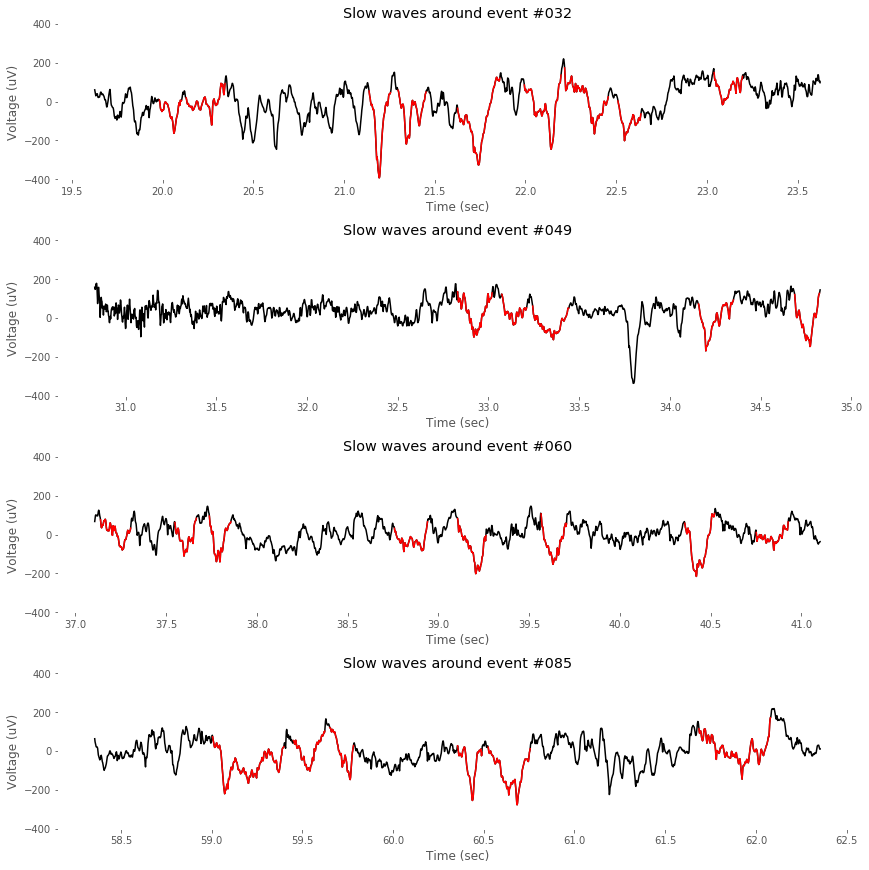

In [12]:
""" Event-by-event visualizer """
cut_epoch = (-int(fs*2),int(fs*2)) # unit:sec
sample_events = [32, 49, 60, 85]
n_samples = len(sample_events)
counter = 1

# For easy visualization
indices_swa = np.zeros(data.shape, dtype='bool')
for ii in range(swa_idx.shape[0]): indices_swa[swa_idx[ii,0]:swa_idx[ii,1]] = True
data_swa = data.copy()
data_swa[np.where(~indices_swa)] = np.nan

# Visualization code
plt.figure(figsize=(12,12))
for evIdx in sample_events:#range(n_event):
    x_epoch = t[swa_idx[evIdx,0]+cut_epoch[0]:swa_idx[evIdx,0]+cut_epoch[1]]
    y_epoch = data[swa_idx[evIdx,0]+cut_epoch[0]:swa_idx[evIdx,0]+cut_epoch[1]]
    y_epoch_swa = data_swa[swa_idx[evIdx,0]+cut_epoch[0]:swa_idx[evIdx,0]+cut_epoch[1]]
    
    plt.subplot(n_samples,1,counter); counter+=1
    plot( x_epoch, y_epoch, 'k' )
    plot( x_epoch, y_epoch_swa, 'r' )
    ylim((-400,400))
    xlabel('Time (sec)')
    ylabel('Voltage (uV)')
    title('Slow waves around event #%03d'%evIdx)
    plt.gca().set_facecolor((1,1,1))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig( '%sFig_QQ_TutorialSWA.jpg'%(figure_directory), dpi=figure_dpi )


#### 2. Detection of Spindles

Similarly, detection and visualization of spindle events can be done by following scripts.

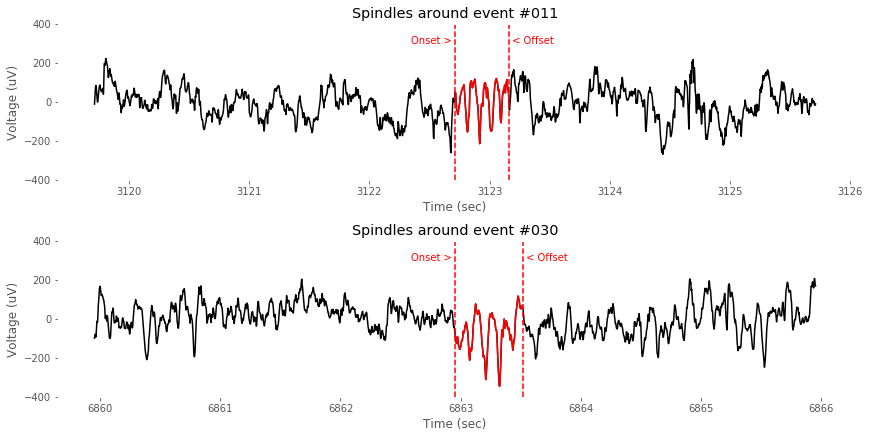

In [13]:
""" Spindle Detection Function """
from scipy import signal
def detect_spindle( data, fs=500, param_band = (8,18), param_thr=(5, 2.5, .3, .1) ):
    spindlef = bandpass_filt( data, band=param_band, fs=fs )
    thr_updown = ( np.std(spindlef)*param_thr[0], np.std(spindlef)*param_thr[1] )
    thr_duration = param_thr[2] # sec
    thr_interval = param_thr[3] # sec
    hilb_amptd = np.abs( signal.hilbert( spindlef ))
    amptd_envelop = smooth( hilb_amptd, fs/5 )
    big_enough = np.where(amptd_envelop>thr_updown[1])[0]
    idx_merged = np.array([])
    if len(big_enough)>0:
        # Duration Thresholding
        start_end = find_seg( big_enough )
        long_enough = start_end[np.where( (start_end[:,1]-start_end[:,0])>(thr_duration*fs))[0],:]
        # Amplitude Thresholding
        include_flag = []
        for i in range(long_enough.shape[0]):
          data_to_inspect = data[range(long_enough[i,0],long_enough[i,1])]
          if len( np.where(data_to_inspect>thr_updown[0])[0])==0:
            include_flag.append(i)
        strong_enough = long_enough[include_flag,:]
        # Merging short interval events
        idx_merged = strong_enough.copy()
        interval = strong_enough[1:,0] - strong_enough[0:-1,1]
        id_to_merge = np.where(interval < thr_interval*fs)[0]
        for j in range(len(id_to_merge))[::-1]:
          idx_merged[id_to_merge[j],1]= idx_merged[id_to_merge[j]+1,1]
          idx_merged = np.delete(idx_merged, id_to_merge[j]+1,axis=0)
    return idx_merged, amptd_envelop

""" Calculation: Spindle """
data = EEG_hdeeg.data[3,:]
spindle_idx, amptd_envelop = detect_spindle( data, fs )

""" Spindle: event-by-event visualizer """
cut_epoch = (-int(fs*3),int(fs*3)) # unit:sec
n_event = spindle_idx.shape[0]

sample_events = [11,30]
n_samples = len(sample_events)
counter = 1
# Visualization code
plt.figure(figsize=(12,6))
for evIdx in sample_events:
    
    # Epoching
    x = t[spindle_idx[evIdx,0]:spindle_idx[evIdx,1]]
    y = data[spindle_idx[evIdx,0]:spindle_idx[evIdx,1]]
    x_epoch = t[spindle_idx[evIdx,0]+cut_epoch[0]:spindle_idx[evIdx,0]+cut_epoch[1]]
    y_epoch = data[spindle_idx[evIdx,0]+cut_epoch[0]:spindle_idx[evIdx,0]+cut_epoch[1]]
    
    # Plotting
    plt.subplot(2,1,counter); 
    plot( x_epoch, y_epoch, 'k' )
    plot( x, y, 'r' )
    plt.ylim((-400,400))
    counter+=1
    plot( [0,0]+t[spindle_idx[evIdx,0]],plt.ylim(), color=(1,0,0), linestyle = '--' )
    plot( [0,0]+t[spindle_idx[evIdx,1]],plt.ylim(), color=(1,0,0), linestyle = '--' )
    plt.text(t[spindle_idx[evIdx,0]], 300, 'Onset > ', horizontalalignment = 'right', color=(1,0,0))
    plt.text(t[spindle_idx[evIdx,1]], 300, ' < Offset', horizontalalignment = 'left', color=(1,0,0))

    xlabel('Time (sec)')
    ylabel('Voltage (uV)')
    title('Spindles around event #%03d'%evIdx)
    plt.gca().set_facecolor((1,1,1))

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig( '%sFig_QQ_TutorialSpindle.jpg'%(figure_directory), dpi=figure_dpi )
plt.show();
    

#### 3. Multi-channel detection of Spindle and SWA activities

The detection functions above were designed for single-channel data only, however, we have 36-channel hdEEG data. To detect sleep-related EEG activities in multi-channel, following two functions detect_swa_multichan() and detect_spindles_multichan() are introduced by slightly modifying the original functions. FYI, threshold parameters for detection are adjusted to cover channel-variant voltage range.


In [32]:
"""  Define functions: Detection in multiple channels """
# (1) SWA
def detect_swa_multichan(data, fs=500, t=EEG_hdeeg.times, shift_band = (.05, 6),
               thr_duration = (0.12, 0.70), thr_std = .7, thr_xcorr = 0.7):
    
    # Data filtering & downshifting
    data_filt_all, data_shift_all = data.copy(), data.copy()
    for chanIdx in range(data.shape[0]):
        data_filt_all[chanIdx,:] = bandpass_filt( data[chanIdx,:], band=shift_band, fs=fs )
        data_shift_all[chanIdx,:] = data_filt_all[chanIdx,:].reshape(-1) - get_upper_envelope(data_filt_all[chanIdx,:],t)
    std_data = np.std( data_shift_all.flatten() )
    
    idx_swas = []
    for chanIdx in range(data.shape[0]):
        data_filt = data_filt_all[chanIdx,:]
        data_shift = data_shift_all[chanIdx,:]
    
        # Get upper/lower indeces near zero
        cross_negative = np.insert( find( data_shift<0 ), 0,0)
        cross_positive = find( data_shift>=0 )
        ups = cross_negative[ find(np.diff(cross_negative)>1) ]+1
        downs = cross_positive[ find(np.diff(cross_positive)>1) ]
        if downs[0] < ups[0]:
            min_length = min(downs.shape[0], ups.shape[0]);
            updowns=np.array( [list(downs),list(ups) ])
        else:
            min_length = min(downs.shape[0], ups.shape[0]-1);
            updowns=np.array( [downs[0:min_length-1],ups[1:min_length] ])
    
        # Main inspection loop
        result = []
        for j in range(min_length-1):
            data_piece = data_shift[updowns[0][j]:updowns[1][j]]
            min_where = np.argmin(data_piece)
            n =len(data_piece)
      
            # Rejection criteria
            flag_long = n < (thr_duration[0]*fs)
            flag_short = n >= (thr_duration[1]*fs)
            flag_amptd = np.max(np.abs(data_piece)) < (std_data*thr_std)
            shift_squared = np.diff(data_filt[updowns[0][j]:updowns[1][j]-1])*np.diff(data_filt[updowns[0][j]+1:updowns[1][j]])
            n_inflection = find(shift_squared<0).shape[0]
            flag_inflection = n_inflection>2
            reject = flag_long | flag_short | flag_amptd | flag_inflection

            # Calculate correlation coefficient
            if not reject:
                min_where = np.argmin(data_piece)
                templateL = np.arange(0,min_where) / (min_where-1)
                templateR = np.arange(0,n-min_where)[::-1] / (n-min_where) 
                template = np.concatenate((templateL,templateR),axis=0)*np.min(data_piece)
                template[find(np.isnan(template))]=0
                r, _ = pearsonr( template, data_piece )
                if r > thr_xcorr: 
                    result.append([updowns[0][j],updowns[1][j]])
        idx_swas.append(np.array(result, dtype=int))
    return idx_swas

# (2) Spindles
def detect_spindle_multichan( data, fs=500, param_band = (8,18), param_thr=(14, 1.6, .5, .1) ):
    spindlef, amptd_envelop = data.copy(), data.copy()
    for chanIdx in range(data.shape[0]):
        spindlef[chanIdx,:] = bandpass_filt( data[chanIdx,:], band=param_band, fs=fs )
        amptd_envelop[chanIdx,:] = smooth(np.abs(signal.hilbert(spindlef[chanIdx,:])), fs/5 )
        
    std_all = np.std( spindlef.flatten() )
    thr_updown = ( std_all*param_thr[0], std_all*param_thr[1] )
    thr_duration = param_thr[2] # sec
    thr_interval = param_thr[3] # sec
    big_enough_all = amptd_envelop>thr_updown[1]
    idx_spindles = []
    for chanIdx in range(data.shape[0]):
        idx_merged = np.array([])
        big_enough = np.where(big_enough_all[chanIdx,:])[0]
        if len(big_enough)>0:
            # Duration Thresholding
            start_end = find_seg( big_enough )
            if start_end.shape[0]:
                long_enough = start_end[np.where( (start_end[:,1]-start_end[:,0])>(thr_duration*fs))[0],:]
                # Amplitude Thresholding
                include_flag = []
                for i in range(long_enough.shape[0]):
                  data_to_inspect = data[chanIdx,range(long_enough[i,0],long_enough[i,1])]
                  if len( np.where(data_to_inspect>thr_updown[0])[0])==0:
                    include_flag.append(i)
                strong_enough = long_enough[include_flag,:]
                # Merging short interval events
                idx_merged = strong_enough.copy()
                interval = strong_enough[1:,0] - strong_enough[0:-1,1]
                id_to_merge = np.where(interval < thr_interval*fs)[0]
                for j in range(len(id_to_merge))[::-1]:
                  idx_merged[id_to_merge[j],1]= idx_merged[id_to_merge[j]+1,1]
                  idx_merged = np.delete(idx_merged, id_to_merge[j]+1,axis=0)
        idx_spindles.append( idx_merged )
    return idx_spindles

Now we have multi-channel detection functions for both SWA and Spindles, let's try it on example dataset.

In [73]:
# Sample data selection
_, EEG_hdeeg, sleep_score = load_data(2, 6, verbose=False) # selection of arbitrary data
data_filtered = EEG_hdeeg.data.copy() # for visualization
for chanIdx in range(data_filtered.shape[0]): data_filtered[chanIdx,:]=bandpass_filt(data_filtered[chanIdx,:],band=(1,50))            

# Multi-channel detection of sleep-related EEG activities 
print('Calculating multi-channel spindle and swas... it takes time (3-5 minutes)')
idx_spindles = detect_spindle_multichan( EEG_hdeeg.data )
idx_swas = detect_swa_multichan( EEG_hdeeg.data )

** Data loading ... Subject 3, Session 7 (Step: R1) **
D:/SciData_Bowon_Sleep/data_BIDS_0812/sub-03/ses-07/eeg/sub-03-R1_screw
Calculating multi-channel spindle and swas... it takes time (3-5 minutes)


After running detection scripts, visualization of multi-channel data can be performed as follow. In case of bad channel, we're gonna skip drawing it.

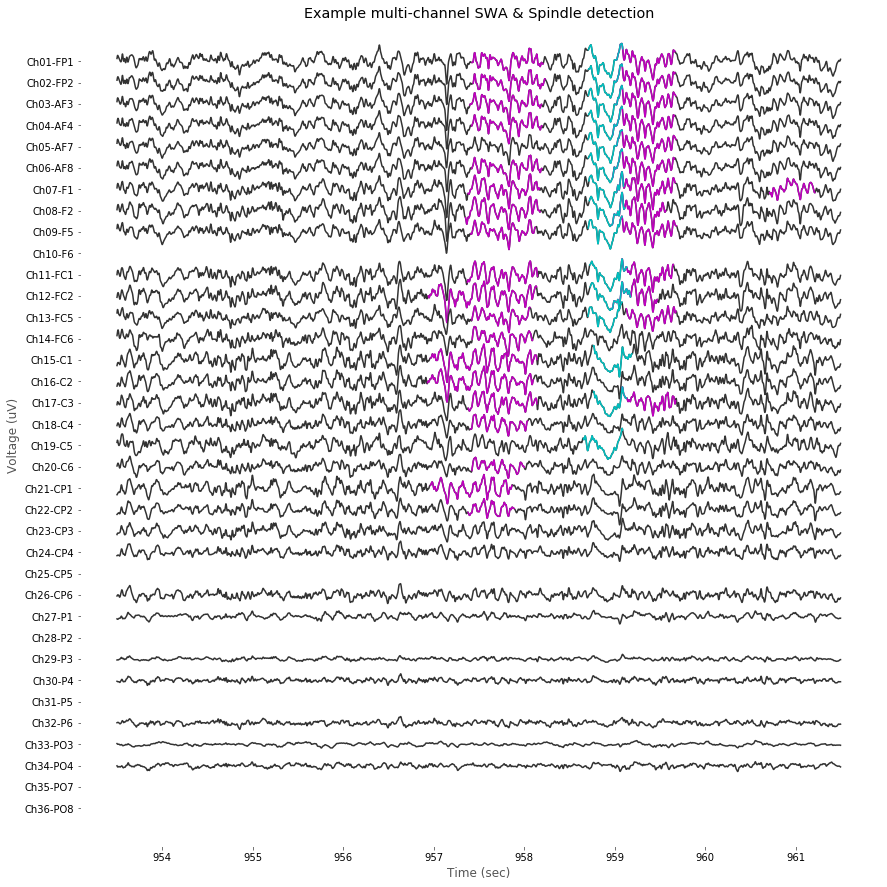

In [76]:
# Visualization 
plt.figure(figsize=(12,12)); plt.subplot(111)
spacing=5100
y_center = np.linspace( -spacing, spacing, int(data_filtered.shape[0]) )
xlims = (953.5,961.5); t_idx = find_idx( xlims, EEG_hdeeg.times ) # selection of arbitrary time window
for chanIdx in range(data_filtered.shape[0]):
    bad_channel = bool( list( EEG_hdeeg.bad_channels ).count(chanIdx) )
    if not bad_channel:
        # Plot raw data
        x_epoch = EEG_hdeeg.times[t_idx[0]:t_idx[1]]
        y_epoch = data_filtered[chanIdx,t_idx[0]:t_idx[1]]
        line1 = plot( x_epoch, y_epoch-y_center[chanIdx], color=[.2,.2,.2] )
        # Mark Spindles
        spindle_idx = idx_spindles[chanIdx]
        for evIdx in range(spindle_idx.shape[0]):
            if (spindle_idx[evIdx,0]>=t_idx[0])&(spindle_idx[evIdx,1]<=t_idx[1]):
                x = EEG_hdeeg.times[ spindle_idx[evIdx,0]:spindle_idx[evIdx,1] ]
                y = data_filtered[chanIdx,spindle_idx[evIdx,0]:spindle_idx[evIdx,1]]
                line2 = plot(x,y-y_center[chanIdx],'m')
        # Mark SWAs
        swa_idx = idx_swas[chanIdx]
        for evIdx in range(swa_idx.shape[0]):
            if (swa_idx[evIdx,0]>=t_idx[0])&(swa_idx[evIdx,1]<=t_idx[1]):
                x = EEG_hdeeg.times[ swa_idx[evIdx,0]:swa_idx[evIdx,1] ]
                y = data_filtered[chanIdx,swa_idx[evIdx,0]:swa_idx[evIdx,1]]
                line3 = plot(x,y-y_center[chanIdx],'c')

        plt.xticks(color=[0,0,0]); plt.yticks(color=[0,0,0])
        plt.yticks(y_center, EEG_hdeeg.ch_names[::-1]);
        plt.ylim((-1.10*spacing,1.10*spacing))
    
plt.title('Example multi-channel SWA & Spindle detection')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.gca().set_facecolor((1,1,1))
xlabel('Time (sec)'); ylabel('Voltage (uV)')
plt.savefig( '%sFig_QQ_ExampleMultiDetection.jpg'%(figure_directory), dpi=figure_dpi );

### 3-3) Time-frequency transformation (Spectrogram)

In many cases, EEG signals are transformed into time-frequency representation. In our demonstration, we'll calculate delta-band (1-4 Hz) and theta-band (4-13 Hz) powers to compare NREM vs. REM sleep EEGs. Function get_spectrogram() which takes multi-channel time domain EEG data (channel * time) to produce time-frequency domain EEG data (time * frequency * channel) is provided below. 


Calc Spec.. shape: (36, 3600000), winsize: [2048], t_res: [2] s
Done: spectrogram calculation


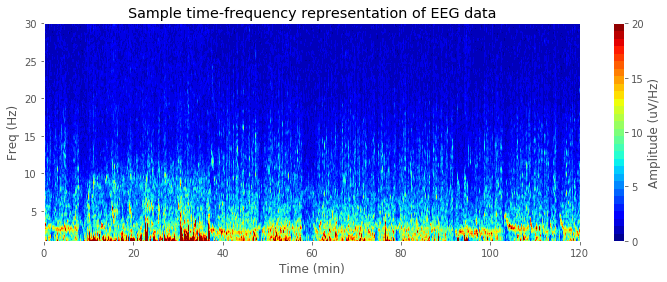

In [7]:
# Spectrogram function
def get_spectrogram( data, t=EEG_hdeeg.times, fs=500, 
                    fft_win_size=2**11, t_resolution=2, freq_cut = None, verbose = False): 
  if verbose:print('Calc Spec.. shape: %s, winsize: [%04d], t_res: [%d] s'%(data.shape,fft_win_size,t_resolution))

  # Spectrogram time vector
  t_fft = [t[0]+(((fft_win_size*.5)+1)/fs),
           t[-1]-(((fft_win_size*.5)+1)/fs)];
  t_vec = np.linspace( t_fft[0], t_fft[-1], int(np.diff(t_fft)/t_resolution)+1);
  
  # Memory pre-occupation
  n_ch, n_t = data.shape[0], len(t_vec)
  _,f = fft_half( np.zeros(fft_win_size), fs);
  if freq_cut is None:
    n_f = len(f)
    Spec_f = f;
  else:
    n_f = np.where(f<freq_cut)[0][-1]+1;
    Spec_f = f[0:n_f];
  Spec = np.zeros((n_t, n_f, n_ch), dtype='float16');

  # Get sliding window indicies
  idx = np.zeros((len(t_vec),2), dtype='int')
  for tIdx in range(len(t_vec)):
    idx_center=np.where(t<t_vec[tIdx])[0][-1]
    idx[tIdx,0] = int(idx_center-fft_win_size*.5)
    idx[tIdx,1] = int(idx_center+fft_win_size*.5-1)
  short = np.where(~(np.diff(idx,1)==fft_win_size-1 ))
  idx[short,1] = idx[short,1]+1
  Spec_t = t[np.array(np.mean(idx,1), dtype='int')];
    
  # FFT calculation
  hann = np.hanning( fft_win_size-1 );
  for chanIdx in range(n_ch):
    epoch = data[chanIdx, :];
    for tIdx in range(len(t_vec)):
      d =  hann * epoch[idx[tIdx,0]:idx[tIdx,1]]
      [x,f]= fft_half(d, fs);
      if freq_cut is None:
        if len(x) < n_f:
            Spec[tIdx,:-1,chanIdx] = abs(x);
        else:
            Spec[tIdx,:,chanIdx] = abs(x);
      else:
        Spec[tIdx,:,chanIdx] = abs(x[:n_f]);
  if verbose: print('Done: spectrogram calculation')
  return np.squeeze(Spec), Spec_t, Spec_f

# Calculate spectrogram
Spec, Spec_t, Spec_f = get_spectrogram( data = EEG_hdeeg.data, t = EEG_hdeeg.times, verbose = True)

# Sample channel visualization
from matplotlib.pyplot import cm
for chanIdx in range(1):
    plt.figure(figsize=(12,4))
    plt.contourf( Spec_t/60, Spec_f, Spec[:,:,chanIdx].transpose(),
               cmap=cm.jet, levels = np.linspace(0,20,30))
    plt.xlim((0,120))
    plt.ylim((1,30))
    plt.xlabel('Time (min)')
    plt.ylabel('Freq (Hz)')
    cbar = plt.colorbar(ticks=(0,5,10,15,20))
    cbar.set_label('Amplitude (uV/Hz)')
    plt.title('Sample time-frequency representation of EEG data')
    plt.savefig( '%sFig_QQ_TutorialSpectrogram.jpg'%(figure_directory), dpi=figure_dpi )


### 3-4) Topographical reconstruction of HD-EEG 

Using channel coordinates, spectral/temporal features of EEG data can be visualized spatially. Scripts below provides a demonstration of topographical reconstruction of (1) delta power during NREM sleep, and (2) theta power during REM sleep as function of experimental condition (e.g., sleep deprivation). To select related timepoints (i.e., NREM and REM periods) from spectrogram, sleep stage label data should be prepared. As our sleep stage label data and the spectrogram calculated above have different sampling rate, it should be matched first. 


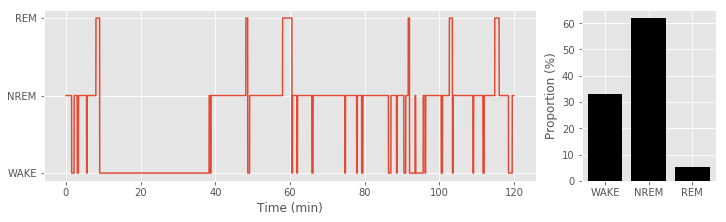

In [8]:
# Scaling sleep state
sleep_state = np.zeros( (EEG_screw.data.shape[1],1), dtype='float16' )
state_label = ['WAKE', 'NREM', 'REM']
srate_factor_upscale = int(EEG_screw.data.shape[1] / sleep_score.shape[0])
for stateIdx in range(len(state_label)):
    for tIdx in np.where( sleep_score['type'] == state_label[stateIdx] )[0]:
        sleep_state[tIdx*srate_factor_upscale:(tIdx+1)*srate_factor_upscale] = stateIdx+1

# Slicing HDEEG-existing part & resizing
t_ZT1_ZT3 = [int(19*EEG_screw.info['sfreq']*(60**2)), int(21*EEG_screw.info['sfreq']*(60**2))]
sleep_state_hdeeg = sleep_state[t_ZT1_ZT3[0]:t_ZT1_ZT3[1]]
sleep_state_spec = np.round((np.array( resize(sleep_state_hdeeg, (Spec_t.shape[0],1), interp = 'nearest' ), dtype='int32')/256)*2)

# Visualization
plt.figure(figsize=(10,3))
plt.subplot(1,4,(1,3))
plt.plot( Spec_t/60, sleep_state_spec )
plt.yticks((0,1,2), labels=state_label)
xlabel('Time (min)');

# Count proportion of each state
plt.subplot(1,4,(4))
for stateIdx in [0,1,2]:
    plt.bar(stateIdx, 100*np.where(sleep_state_spec==stateIdx)[0].shape[0]/sleep_state_spec.shape[0], color='k')
plt.xticks((0,1,2), labels=state_label)
ylabel('Proportion (%)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig( '%sFig_QQ_TutorialLabeling.jpg'%(figure_directory), dpi=figure_dpi )


Next, we need to extract band power information of each channel to draw topographical map. To easily extract specific band power with given state, we made a handy function bandpower_state() as below. It slices in temporal and frequency domain for corresponding point of sleep state and frequency bin, respectively. 

In [9]:
def bandpower_state( data=(Spec,Spec_t,Spec_f),sleep_state=sleep_state_spec,
                    band_name='delta',state_name='NREM'):
    band_dict = {'delta':[1,4], 'theta':[5,10], 'high_gamma':[100,250], 'overall':[1,250]}
    state_dict = {'WAKE':0, 'NREM':1, 'REM':2}
    band, state = band_dict[band_name], state_dict[state_name]
    bandIdx = (np.where(Spec_f<band[0])[0][-1]+1, np.where(Spec_f<band[1])[0][-1])
    stateIdx = np.where( sleep_state == state )[0]
    seg = find_seg(stateIdx)
    data = np.zeros((0,36))
    for segIdx in range(seg.shape[0]):
        tIdx = (np.where( Spec_t<Spec_t[seg[segIdx,0]] )[0][-1]+1, 
                np.where( Spec_t<Spec_t[seg[segIdx,1]] )[0][-1])
        data = np.concatenate((data, np.mean( Spec[tIdx[0]:tIdx[1],bandIdx[0]:bandIdx[1],:], axis=1 )), 0)
    return np.squeeze(np.mean(data,0))

# Example Callback of function & bad channel rejection
data_topo = bandpower_state((Spec,Spec_t,Spec_f), sleep_state_spec, 'delta', 'NREM')
data_topo[EEG_hdeeg.bad_channels] = np.nan
data_topo[EEG_hdeeg.bad_channels] = np.nanmedian(data_topo)


Finally, we need 2D interpolation function to draw power topography from given power distribution sampled at electrode points. 

In [10]:
# Preparation of 2D power topography
""" (1) Class for 2D interpolation """
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

class bi_interp2:
  def __init__(self, x, y, z, xb, yb, xi, yi, method='linear'):
    self.x = x
    self.y = y
    self.z = z
    self.xb = xb
    self.yb = yb
    self.xi = xi
    self.yi = yi
    self.x_new, self.y_new = np.meshgrid(xi, yi)
    self.id_out = np.zeros([len(self.xi), len(self.xi)], dtype='bool')
    self.x_up, self.y_up, self.x_dn, self.y_dn = [], [], [], []
    self.interp_method = method
    self.z_new = []

  def __call__(self):
    self.find_boundary()
    self.interp2d()
    return self.x_new, self.y_new, self.z_new

  def find_boundary(self):
    self.divide_plane()
    # sort x value
    idup = self.sort_arr(self.x_up)
    iddn = self.sort_arr(self.x_dn)
    self.x_up = self.x_up[idup]
    self.y_up = self.y_up[idup]
    self.x_dn = self.x_dn[iddn]
    self.y_dn = self.y_dn[iddn]
    self.remove_overlap()
    # find outline, use monotone cubic interpolation
    ybnew_up = self.interp1d(self.x_up, self.y_up, self.xi)
    ybnew_dn = self.interp1d(self.x_dn, self.y_dn, self.xi)
    for i in range(len(self.xi)):
        idt1 = self.y_new[:, i] > ybnew_up[i]
        idt2 = self.y_new[:, i] < ybnew_dn[i]
        self.id_out[idt1, i] = True
        self.id_out[idt2, i] = True
    # expand data points
    self.x = np.concatenate((self.x, self.x_new[self.id_out].flatten(), self.xb))
    self.y = np.concatenate((self.y, self.y_new[self.id_out].flatten(), self.yb))
    self.z = np.concatenate((self.z, np.zeros(np.sum(self.id_out) + len(self.xb))))

  def interp2d(self):
    pts = np.concatenate((self.x.reshape([-1, 1]), self.y.reshape([-1, 1])), axis=1)
    self.z_new = interpolate.griddata(pts, self.z, (self.x_new, self.y_new), method=self.interp_method)
    self.z_new[self.id_out] = np.nan
    
  def remove_overlap(self):
    id1 = self.find_val(np.diff(self.x_up) == 0, None)
    id2 = self.find_val(np.diff(self.x_dn) == 0, None)
    for i in id1:
      temp = (self.y_up[i] + self.y_up[i+1]) / 2
      self.y_up[i+1] = temp
      self.x_up = np.delete(self.x_up, i)
      self.y_up = np.delete(self.y_up, i)
    for i in id2:
      temp = (self.y_dn[i] + self.y_dn[i + 1]) / 2
      self.y_dn[i+1] = temp
      self.x_dn = np.delete(self.x_dn, i)
      self.y_dn = np.delete(self.y_dn, i)

  def divide_plane(self):
    ix1 = self.find_val(self.xb == min(self.xb), 1)
    ix2 = self.find_val(self.xb == max(self.xb), 1)
    iy1 = self.find_val(self.yb == min(self.yb), 1)
    iy2 = self.find_val(self.yb == max(self.yb), 1)
    # divide the plane with Quadrant
    qd = np.zeros([self.xb.shape[0], 4], dtype='bool')
    qd[:, 0] = (self.xb > self.xb[iy2]) & (self.yb > self.yb[ix2])
    qd[:, 1] = (self.xb > self.xb[iy1]) & (self.yb < self.yb[ix2])
    qd[:, 2] = (self.xb < self.xb[iy1]) & (self.yb < self.yb[ix1])
    qd[:, 3] = (self.xb < self.yb[iy2]) & (self.yb > self.yb[ix1])
    # divide the array with y axis
    self.x_up = self.xb[qd[:, 0] | qd[:, 3]]
    self.y_up = self.yb[qd[:, 0] | qd[:, 3]]
    self.x_dn = self.xb[qd[:, 1] | qd[:, 2]]
    self.y_dn = self.yb[qd[:, 1] | qd[:, 2]]

  def find_val(self, condition, num_of_returns):
    # find the value that satisfy the condition
    ind = np.where(condition == 1)
    return ind[:num_of_returns]

  def sort_arr(self, arr):
    # return sorting index
    return sorted(range(len(arr)), key=lambda i: arr[i])

  def interp1d(self, xx, yy, xxi):
    # find the boundary line
    interp_obj = interpolate.PchipInterpolator(xx, yy)
    return interp_obj(xxi)
  
""" (2) Function for Topography plot """
from matplotlib import cm
from pandas import read_csv
montage_file = 'D:/SciData_Bowon_Sleep/montage.csv'
from mpl_toolkits.mplot3d import Axes3D

def get_boundary():
 return np.array([
    -4.400, 0.030, -4.180, 0.609, -3.960, 1.148, -3.740, 1.646, -3.520, 2.105, -3.300, 2.525, -3.080, 2.908, -2.860, 3.255,
    -2.640, 3.566, -2.420, 3.843, -2.200, 4.086, -1.980, 4.298, -1.760, 4.4799, -1.540, 4.6321, -1.320, 4.7567, -1.100, 4.8553,
    -0.880, 4.9298, -0.660, 4.9822, -0.440, 5.0150, -0.220, 5.0312,0, 5.035, 0.220, 5.0312, 0.440, 5.0150, 0.660, 4.9822,
    0.880, 4.9298, 1.100, 4.8553, 1.320, 4.7567, 1.540, 4.6321,1.760, 4.4799, 1.980, 4.2986, 2.200, 4.0867, 2.420, 3.8430,
    2.640, 3.5662, 2.860, 3.2551, 3.080, 2.9087, 3.300, 2.5258,3.520, 2.1054, 3.740, 1.6466, 3.960, 1.1484, 4.180, 0.6099,
    4.400, 0.0302, 4.400, 0.0302, 4.467, -0.1597, 4.5268, -0.3497,4.5799, -0.5397, 4.6266, -0.7297, 4.6673, -0.9197, 4.7025, -1.1097,
    4.7326, -1.2997, 4.7579, -1.4897, 4.7789, -1.6797, 4.7960, -1.8697,4.8095, -2.0597, 4.8199, -2.2497, 4.8277, -2.4397, 4.8331, -2.6297,
    4.8366, -2.8197, 4.8387, -3.0097, 4.8396, -3.1997, 4.8399, -3.3897,4.8384, -3.5797, 4.8177, -3.7697, 4.7776, -3.9597, 4.7237, -4.1497,
    4.6620, -4.3397, 4.5958, -4.5297, 4.5021, -4.7197, 4.400, -4.8937,4.1800, -5.1191, 3.9600, -5.3285, 3.7400, -5.5223, 3.5200, -5.7007,
    3.3000, -5.8642, 3.0800, -6.0131, 2.8600, -6.1478, 2.6400, -6.2688,2.4200, -6.3764, 2.2000, -6.4712, 1.9800, -6.5536, 1.7600, -6.6241,
    1.5400, -6.6833, 1.3200, -6.7317, 1.1000, -6.7701, 0.8800, -6.7991,0.6600, -6.8194, 0.4400, -6.8322, 0.2200, -6.8385, 0, -6.840,
    -0.220, -6.8385, -0.440, -6.8322, -0.660, -6.8194, -0.880, -6.7991,-1.100, -6.7701, -1.320, -6.7317, -1.540, -6.6833, -1.760, -6.6241,
    -1.980, -6.5536, -2.200, -6.4712, -2.420, -6.3764, -2.640, -6.2688,-2.860, -6.1478, -3.080, -6.0131, -3.300, -5.8642, -3.520, -5.7007,
    -3.740, -5.5223, -3.960, -5.3285, -4.180, -5.1191, -4.400, -4.89370,-4.5021, -4.7197, -4.5958, -4.5297, -4.6620, -4.3397, -4.7237, -4.1497,
    -4.7776, -3.9597, -4.8177, -3.7697, -4.8384, -3.5797, -4.8399, -3.3897,-4.8397, -3.1997, -4.8387, -3.0097, -4.8367, -2.8197, -4.8331, -2.6297,
    -4.8277, -2.4397, -4.8200, -2.2497, -4.8095, -2.0597, -4.7960, -1.8697,-4.7789, -1.6797, -4.7579, -1.4897, -4.7326, -1.2997, -4.7025, -1.1097,
    -4.6673, -0.9197, -4.6266, -0.7297, -4.5799, -0.5397, -4.5268, -0.3497,-4.4670, -0.1597, -4.4000, 0.03025]).reshape(-1, 2)

def plot_topo2d(data, plot_opt = True, clim=(-5,5), montage_file=montage_file, topo_resolution = (500,500)):
  # Zero-padding
  short = 38-len(data)
  if short: data=np.concatenate((data, np.tile(.00000001, short)), axis=0)
  # Get head boundary image coordinates
  boundary = get_boundary()
  montage_table = read_csv(montage_file)
  x, y = np.array(montage_table['X_ML']), np.array(montage_table['Y_AP'])
  xb, yb = boundary[:, 0], boundary[:, 1]
  xi, yi = np.linspace(min(xb), max(xb), topo_resolution[0]),np.linspace(min(yb), max(yb), topo_resolution[1])
  xx, yy, topo_data = bi_interp2(x, y, data, xb, yb, xi, yi)()
  if plot_opt:
    topo_to_draw = topo_data.copy()
    topo_to_draw[np.where(topo_data>clim[1])] = clim[1]
    topo_to_draw[np.where(topo_data<clim[0])] = clim[0]
    plt.contourf(xx, yy, topo_to_draw, cmap=cm.jet, levels = np.linspace(clim[0],clim[1],50))
    plt.grid(False)
    plt.gca().set_aspect('equal','box')
    plt.xlabel('ML coordinate (mm)', fontsize=15);
    plt.ylabel('AP coordinate (mm)', fontsize=15);
    plt.text(0, 0.0, 'BP', color='w', fontsize=10, weight='bold', ha='center',va='center');
    plt.text(0,-4.2, 'LP', color='w', fontsize=10, weight='bold', ha='center',va='center');
    if clim is not None: plt.clim(clim)
    plt.plot(montage_table['X_ML'][0:36],montage_table['Y_AP'][0:36], 'w.')    
    plt.axis( (-5.5, 5.5, -7, 5.2) ) 
    plt.gca().set_facecolor((1,1,1))

  return xx, yy, topo_data

Using above function of plot_topo2d(), power topography of delta-band activity across different sleep state (WAKE, NREM, and REM) can be drawn as follow.

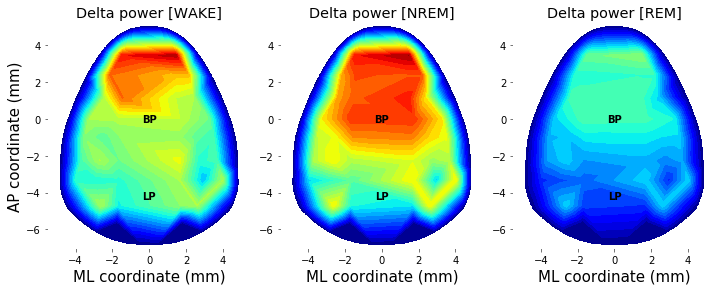

In [11]:
plt.figure(figsize=(10,6))
counter=0
for state in ['WAKE', 'NREM', 'REM']:
    # Get bandpower from each channel
    data_topo = bandpower_state((Spec,Spec_t,Spec_f), sleep_state_spec, 'delta', state)
    data_topo[EEG_hdeeg.bad_channels] = np.nan
    data_topo[EEG_hdeeg.bad_channels] = np.nanmean(data_topo)

    # Transform into 2D topography
    xx,yy,topo_NREM_delta = plot_topo2d( data_topo, plot_opt = False )
    clim=(0,6.5)

    counter += 1
    plt.subplot(1,3,counter)
    plt.contourf(xx, yy, topo_NREM_delta, cmap=cm.jet, levels = np.linspace(clim[0],clim[1],30))
    plt.grid(False)
    plt.gca().set_aspect('equal','box')
    plt.xlabel('ML coordinate (mm)', fontsize=15, color='k');
    if state is 'WAKE': plt.ylabel('AP coordinate (mm)', fontsize=15, color='k');
    plt.text(0, 0.0, 'BP', color='k', fontsize=10, weight='bold', ha='center',va='center');
    plt.text(0,-4.2, 'LP', color='k', fontsize=10, weight='bold', ha='center',va='center');
    plt.axis( (-5.5, 5.5, -7, 5.2) ) 
    plt.gca().set_facecolor((1,1,1))
    plt.xticks(color='k'); plt.yticks(color='k')
    plt.clim(clim)
    title( 'Delta power [%s]'%(state))

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig( '%sFig_QQ_TutorialTopography.jpg'%(figure_directory), dpi=figure_dpi )


### 3-5) Example trace figures
   
   
Below figures depict some example cases of EEG analysis (e.g., drawing multichannel raw data, rich visualization of SWA and spindle) contained in this dataset. For the purpose of demonstration, few pieces of data were arbitrarily selected. 

In [12]:
example_info_trace = { 'subject':1, 'day':6 }
example_info_swa = { 'subject':0, 'day':0, 'event':249 }
example_info_spindle = { 'subject':2, 'day':6, 'event':3 }

** Data loading ... Subject 2, Session 7 (Step: R1) **
Screw data shape: [4 channels x 43200000 times]
Screw bad channels: []
hdEEG data shape: [36 channels x 3600000 times]
hdEEG bad channels: [0, 29, 34]


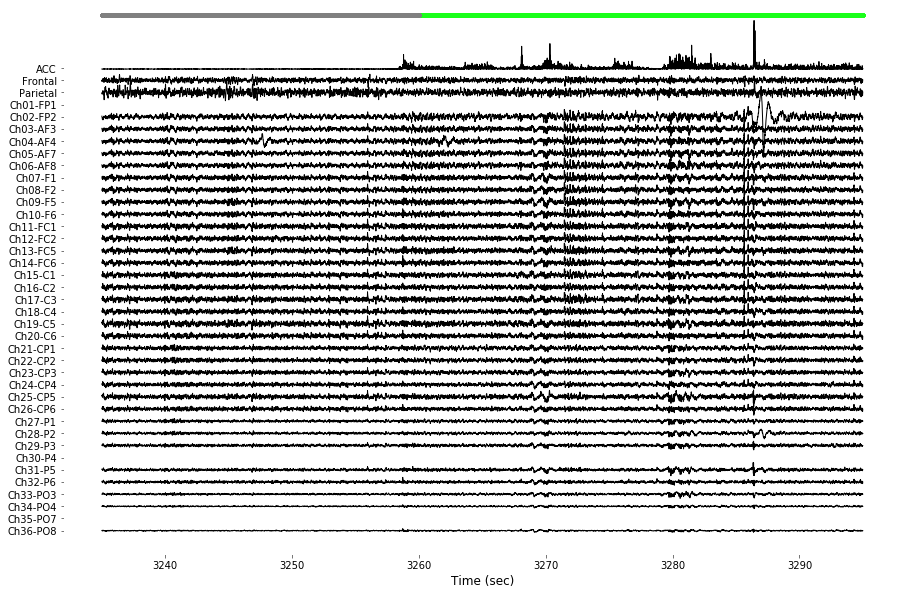

In [13]:
# Figure: Example signal visualization of screw/hdeeg data

# Data selection for figure QQQ
EEG_screw, EEG_hdeeg, sleep_score = load_data(example_info_trace['subject'],example_info_trace['day'], verbose=True)
start_point = int(3235*EEG_screw.info['sfreq'])
data_length = int(60*EEG_screw.info['sfreq'])
toi = (start_point+0,start_point+data_length-1)
t_toi = EEG_hdeeg.times[toi[0]:toi[1]]
hdeeg_toi = EEG_hdeeg.data[:,toi[0]:toi[1]]
hdeeg_toi[ EEG_hdeeg.bad_channels, :] = np.nan
screw_toi = EEG_screw.data[:2,t_ZT1_ZT3[0]+toi[0]:t_ZT1_ZT3[0]+toi[1]]
acc_toi = abs(EEG_screw.data[2:3,t_ZT1_ZT3[0]+toi[0]:t_ZT1_ZT3[0]+toi[1]])
data_toi = np.concatenate((10*acc_toi, 2*screw_toi, hdeeg_toi), axis=0 )

# Filter EEG data (1-50 Hz)
for chIdx in range(1,data_toi.shape[0]): data_toi[chIdx,:] = bandpass_filt(data_toi[chIdx,:], band=(1,50))

# Rescaling sleep state data
sleep_state = np.zeros( (EEG_screw.data.shape[1],1), dtype='float16' )
state_label = ['WAKE', 'NREM', 'REM']
score_exist = sleep_score.shape[0]>0
if score_exist:
    srate_factor_upscale = int(EEG_screw.data.shape[1] / sleep_score.shape[0])
    for stateIdx in range(len(state_label)):
        for tIdx in np.where( sleep_score['type'] == state_label[stateIdx] )[0]:
            sleep_state[tIdx*srate_factor_upscale:(tIdx+1)*srate_factor_upscale] = stateIdx+1
    t_ZT1_ZT3 = [int(19*EEG_screw.info['sfreq']*(60**2)), int(21*EEG_screw.info['sfreq']*(60**2))]
    sleep_state_hdeeg = sleep_state[t_ZT1_ZT3[0]:t_ZT1_ZT3[1]]
    sleep_state_toi_500Hz = np.round(sleep_state_hdeeg)
WAKE = sleep_state_toi_500Hz==1
wake_toi = np.where( WAKE[toi[0]:toi[1]] == 1 )[0]
sleep_toi = np.where( WAKE[toi[0]:toi[1]] == 0 )[0]

# Channel label list for visualization
ch_names = ['ACC', 'Frontal', 'Parietal']; [ ch_names.append(x) for x in EEG_hdeeg.ch_names ]

# Plot multi channels 
x, y = t_toi, data_toi
spacing=8000 
color_template = np.array([[1,.09,.15],[1,.75,.28],[.4,.2,0],[.6,.7,.3],[.55,.55,.08]])*0
color_space = np.tile( color_template, 
                  (int(np.ceil([ float(y.shape[0])/color_template.shape[0]])[0]), 1) )
color_space = np.zeros((y.shape[0],3))
plt.figure(figsize=(15,10))
y_center = np.linspace( -spacing, spacing, int(y.shape[0]) )
for chanIdx in range(y.shape[0]):
    shift = y_center[chanIdx] + np.nanmean(y[chanIdx,:])
    plt.plot(x, y[chanIdx,:]-shift, color=color_space[chanIdx,], linewidth=1);
    plt.xlabel('Time (sec)', color=[0,0,0])
    plt.xticks(color=[0,0,0]); plt.yticks(color=[0,0,0])
    plt.yticks(y_center, ch_names[::-1]);
    plt.ylim((-1.1*spacing,1.25*spacing))

state_indicator_ypos = spacing*1.23
plot( x[wake_toi], np.ones((wake_toi.shape[0],1))*state_indicator_ypos, '.', color=[.1, 1, .1])
plot( x[sleep_toi], np.ones((sleep_toi.shape[0],1))*state_indicator_ypos, '.', color=[.5,.5,.5])
plt.gca().set_facecolor((1,1,1))
plt.savefig( '%sFig_QQ_ExampleTrace.jpg'%(figure_directory), dpi=figure_dpi )
plt.show();



** Data loading ... Subject 1, Session 1 (Step: BL) **
Screw data shape: [4 channels x 43200000 times]
Screw bad channels: []
hdEEG data shape: [36 channels x 3600000 times]
hdEEG bad channels: [9, 12, 22, 27, 31, 34, 35]
[SWA detection] 7796 events are detected


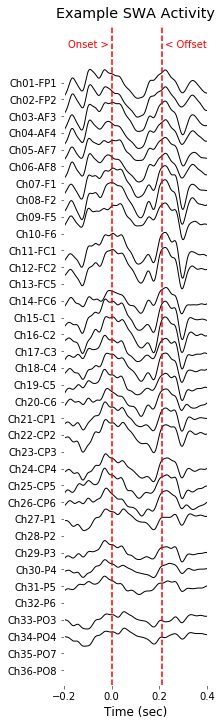

In [14]:
# Figure: Example SWA propagation (anterior to posterior)

# Data selection for figure QQQ
evIdx = example_info_swa['event']
EEG_screw, EEG_hdeeg, sleep_score = load_data(example_info_swa['subject'],example_info_swa['day'], verbose=True)
data, t, fs = EEG_hdeeg.data[3,:], EEG_hdeeg.times, EEG_screw.info['sfreq']
swa_idx, swa_minmax = detect_swa(data, fs=fs, t=t, verbose=True);
data_filtered = EEG_hdeeg.data.copy()
for chIdx in range(data_filtered.shape[0]): data_filtered[chIdx,:] = bandpass_filt(data_filtered[chIdx,:], band=(1,30))            

# Preprocessing for easy visualization
cut_epoch = (-int(fs*.2),int(fs*.4)) # unit:sec

x_epoch = t[swa_idx[evIdx,0]+cut_epoch[0]:swa_idx[evIdx,0]+cut_epoch[1]]
y_epoch = data_filtered[:,swa_idx[evIdx,0]+cut_epoch[0]:swa_idx[evIdx,0]+cut_epoch[1]]
y_epoch[EEG_hdeeg.bad_channels,:] = np.nan

# Plot multi channels 
spacing=3000
color_space = np.zeros((y_epoch.shape[0],3))
plt.figure(figsize=(3,10))
y_center = np.linspace( -spacing, spacing, int(y_epoch.shape[0]) )
for chanIdx in range(y_epoch.shape[0]):
    shift = y_center[chanIdx] + np.nanmean(y_epoch[chanIdx,:])
    plt.plot(x_epoch-t[swa_idx[evIdx,0]], y_epoch[chanIdx,:]-shift, color=color_space[chanIdx,], linewidth=1);
    plt.xlabel('Time (sec)', color=[0,0,0])
    plt.xticks(color=[0,0,0]); plt.yticks(color=[0,0,0])
    plt.yticks(y_center, EEG_hdeeg.ch_names[::-1]);
    plt.ylim((-1.05*spacing,1.20*spacing))
plot( [0,0],plt.ylim(), color=(1,0,0), linestyle = '--' )
plot( [0,0]+t[swa_idx[evIdx,1]]-t[swa_idx[evIdx,0]],plt.ylim(), color=(1,0,0), linestyle = '--' )
plt.text(0, 1.12*spacing, 'Onset > ', horizontalalignment = 'right', color=(1,0,0))
plt.text(t[swa_idx[evIdx,1]]-t[swa_idx[evIdx,0]], 1.12*spacing, ' < Offset', horizontalalignment = 'left', color=(1,0,0))
plt.xlim((-.2,.4))
plt.gca().set_facecolor((1,1,1))

plt.title('Example SWA Activity')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig( '%sFig_QQ_ExampleSWA.jpg'%(figure_directory), dpi=figure_dpi )
plt.show();


** Data loading ... Subject 3, Session 7 (Step: R1) **
Screw data shape: [4 channels x 43200000 times]
Screw bad channels: []
hdEEG data shape: [36 channels x 3600000 times]
hdEEG bad channels: [9, 24, 27, 30, 34, 35]


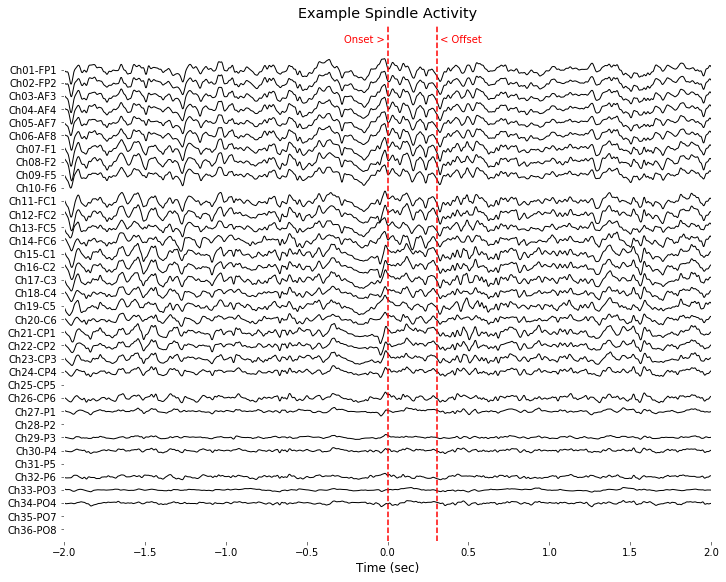

In [15]:
# Data selection for example figure
evIdx = example_info_spindle['event']
EEG_screw, EEG_hdeeg, sleep_score = load_data(example_info_spindle['subject'],example_info_spindle['day'], verbose=True)
data, t, fs = EEG_hdeeg.data[3,:], EEG_hdeeg.times, EEG_screw.info['sfreq']
spindle_idx, amptd_envelop = detect_spindle( data, fs )
data_filtered = EEG_hdeeg.data.copy()
for chIdx in range(data_filtered.shape[0]): data_filtered[chIdx,:] = bandpass_filt(data_filtered[chIdx,:], band=(1,50))            

# Preprocessing for easy visualization
cut_epoch = (-int(fs*2),int(fs*2)) # unit:sec

x_epoch = t[spindle_idx[evIdx,0]+cut_epoch[0]:spindle_idx[evIdx,0]+cut_epoch[1]]
y_epoch = data_filtered[:,spindle_idx[evIdx,0]+cut_epoch[0]:spindle_idx[evIdx,0]+cut_epoch[1]]
y_epoch[EEG_hdeeg.bad_channels,:] = np.nan

plt.figure(figsize=(10,8))
spacing=5000
y_center = np.linspace( -spacing, spacing, int(y_epoch.shape[0]) )
for chanIdx in range(y_epoch.shape[0]):
    shift = y_center[chanIdx] + np.nanmean(y_epoch[chanIdx,:])
    plt.plot(x_epoch-t[spindle_idx[evIdx,0]], y_epoch[chanIdx,:]-shift, color=color_space[chanIdx,], linewidth=1);
    plt.xlabel('Time (sec)', color=[0,0,0])
    plt.xticks(color=[0,0,0]); plt.yticks(color=[0,0,0])
plt.yticks(y_center, EEG_hdeeg.ch_names[::-1]);
plt.ylim((-1.05*spacing,1.20*spacing))
plot( [0,0],plt.ylim(), color=(1,0,0), linestyle = '--' )
plot( [0,0]+t[spindle_idx[evIdx,1]]-t[spindle_idx[evIdx,0]],plt.ylim(), color=(1,0,0), linestyle = '--' )
plt.text(0, 1.12*spacing, 'Onset > ', horizontalalignment = 'right', color=(1,0,0))
plt.text(t[spindle_idx[evIdx,1]]-t[spindle_idx[evIdx,0]], 1.12*spacing, ' < Offset', horizontalalignment = 'left', color=(1,0,0))
plt.title('Example Spindle Activity')
plt.xlim((-2,2))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.gca().set_facecolor((1,1,1))
plt.savefig( '%sFig_QQ_ExampleSpindle.jpg'%(figure_directory), dpi=figure_dpi )
plt.show();


### 3-6) Obtaining grand-averaged results 
   
So far, figures and analyses were focused on the data from single session. To obtain grand-averaged data, we need to use a loop which extract features-of-interest from given dataset. Because of the large size of dataset, the calculation is done one-by-one. This is just an example way of doing it, so please change the pipeline to meet your analysis purpose and environment (large RAM, etc.). 

In [ ]:
# IT TAKES A LOT OF TIME!
calculationOpt = False
if calculationOpt:
    for sbjIdx in range(9):
        list_swa, list_swa_range, list_spindle, list_delta, list_theta = [], [], [], [], []
        list_Spec, list_sleep_state_toi = [], []
        list_highpow = []
        for sessIdx in range(9):

            # (1) Data loading and check availability
            EEG_screw, EEG_hdeeg, sleep_score = load_data( sbjIdx, sessIdx, verbose = False)
            score_exist = sleep_score.shape[0]>0
            hdeeg_exist = EEG_hdeeg is not None

            # (2) SWA & Spindle detection
            spindles, swas, swar = [], [], []
            if hdeeg_exist:
                for chIdx in range(EEG_hdeeg.data.shape[0]):
                    if chIdx in EEG_hdeeg.bad_channels:
                        swa_idx, swa_minmax, spindle_idx = [], [], []
                    else:
                        data, t, fs = EEG_hdeeg.data[chIdx,:], EEG_hdeeg.times, EEG_screw.info['sfreq']
                        swa_idx, swa_minmax = detect_swa(data, fs=fs, t=t);
                        spindle_idx, amptd_envelop = detect_spindle( data, fs )
                    swas.append( swa_idx )
                    swar.append( swa_minmax )
                    spindles.append( spindle_idx )
                list_swa.append( swas )
                list_swa_range.append( swar )
                list_spindle.append( spindles )
            else:
                list_swa.append( [] )
                list_swa_range.append( [] )
                list_spindle.append( [] )

            # (3) Power calculation for topography & signal quality check
            if hdeeg_exist and score_exist:
                # Scaling sleep state
                Spec, Spec_t, Spec_f = get_spectrogram( data = EEG_hdeeg.data, t = EEG_hdeeg.times )

                sleep_state = np.zeros( (EEG_screw.data.shape[1],1), dtype='float16' )
                state_label = ['WAKE', 'NREM', 'REM']
                srate_factor_upscale = int(EEG_screw.data.shape[1] / sleep_score.shape[0])
                for stateIdx in range(len(state_label)):
                    for tIdx in np.where( sleep_score['type'] == state_label[stateIdx] )[0]:
                        sleep_state[tIdx*srate_factor_upscale:(tIdx+1)*srate_factor_upscale] = stateIdx+1
                t_ZT1_ZT3 = [int(19*EEG_screw.info['sfreq']*(60**2)), int(21*EEG_screw.info['sfreq']*(60**2))]
                sleep_state_hdeeg = sleep_state[t_ZT1_ZT3[0]:t_ZT1_ZT3[1]]
                sleep_state_toi = np.round((np.array( resize(sleep_state_hdeeg, (Spec_t.shape[0],1), interp = 'nearest' ), dtype='int32')/256)*2)        
                sleep_state_toi_500Hz = np.round(sleep_state_hdeeg)

                list_Spec.append(Spec)
                list_sleep_state_toi.append(sleep_state_toi)  

            else:
                list_Spec.append([])
                list_sleep_state_toi.append([]) 

        # Save
        data = {'list_swa':list_swa,
                'list_swa_range':list_swa_range,
                'list_spindle':list_spindle,
                'list_sleep_state_toi':list_sleep_state_toi,
                'list_highpow':list_highpow,
                'list_Spec':list_Spec,
                'Spec_t':Spec_t,
                'Spec_f':Spec_f,
                'bad_channels_hdeeg':EEG_hdeeg.bad_channels}
        with open(save_directory+'data_summary-sbj%s.pickle'%(sbjIdx+1), 'wb') as f: pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

With the scripts above, we downsized the individual subject's data from 10.1 GB to 1.5 GB. Through scanning these pickle files, grand-averaged power topography can be obtained as follow.

In [218]:
# Get individual topography data
import pickle
save_directory = ''

topos = np.zeros((500,500,9,9,2,3), dtype='float16')
band_label = ['delta', 'theta']
state_label = ['WAKE', 'NREM', 'REM']
condition_label = ['BL', 'SR1', 'SR2', 'SR3', 'SR4', 'SR5' ,'R1', 'R2', 'R3']    

visualizeOpt = False
for sbjIdx in range(9):
    fname_open =save_directory+'data_summary-sbj%s.pickle'%(sbjIdx+1)
    print('\n---- opening [%s]'%fname_open)
    with open(fname_open, 'rb') as f: data = pickle.load(f)
    
    if sbjIdx == 0: Spec_f, Spec_t = data['Spec_f'], data['Spec_t']
    
    # Data selection
    badch = data['bad_channels_hdeeg']
    powers = np.zeros((36,9,len(band_label),len(state_label)))
    for dayIdx in range(9):
        Spec = data['list_Spec'][dayIdx]
        sleep_state_toi = data['list_sleep_state_toi'][dayIdx]
        if len(Spec)>0:
            if Spec.shape[0] < sleep_state_toi.shape[0]:
                t = Spec_t[:Spec.shape[0]]
                sleep_state_toi = resize( sleep_state_toi, [Spec.shape[0],1] )
            else:
                t = Spec_t
            
            for band in band_label:
                for state in state_label:
                    x = bandpower_state((Spec,t,Spec_f),sleep_state_toi,band,state)
                    x[badch] = np.nan; x[badch] = np.nanmedian(x)
                    powers[:,dayIdx,band_label.index(band),state_label.index(state)] = x
        else:
            powers[:,dayIdx,:,:] = np.nan;

    for bandIdx in [0,1]:
        if bandIdx==0: clim=(0,12)#np.nanmax( powers[:,:,bandIdx,stateIdx].flatten() ))
        else:          clim=(0,6)#np.nanmax( powers[:,:,bandIdx,stateIdx].flatten() ))
        for stateIdx in [0,1,2]:
            if visualizeOpt: 
                plt.figure(figsize=(15,8))
                counter = 0
            for dayIdx in range(9):
                powers_to_draw = powers[:,dayIdx,bandIdx,stateIdx]
                
                outlier_index = np.where( powers_to_draw > (np.nanmean(powers_to_draw)+np.nanstd(powers_to_draw)*2.56))[0]
                powers_to_draw[ outlier_index ] = np.nan;
                powers_to_draw[ outlier_index ] = np.nanmedian(powers_to_draw);
                
                hdeeg_exist = np.mean( np.isnan(powers_to_draw) ) < 1
                xx,yy,topo = plot_topo2d( powers_to_draw, plot_opt = False )
                if not hdeeg_exist: topo[:] = np.nan
                topos[:,:,dayIdx,sbjIdx,bandIdx,stateIdx] = topo
                if visualizeOpt: 
                    plt.contourf(xx, yy, topo, cmap=cm.jet, levels = np.linspace(clim[0],clim[1],30))
                    plt.subplot(1,9,dayIdx+1)
                    plt.grid(False)
                    plt.gca().set_aspect('equal','box')
                    plt.axis( (-5.5, 5.5, -7, 5.2) ) 
                    plt.gca().set_facecolor((1,1,1))
                    plt.xticks([0],color='k'); plt.yticks([0],color='k')
                    plt.clim(clim)
                    title( '[%s]%s %s'%(condition_label[dayIdx],state_label[stateIdx],band_label[bandIdx]), fontsize=9)
            if visualizeOpt: plt.show()
#np.save(save_directory+'topos', topos) # Save it if you want



---- opening [D:/output_ipynb/data_summary-sbj1.pickle]

---- opening [D:/output_ipynb/data_summary-sbj2.pickle]

---- opening [D:/output_ipynb/data_summary-sbj3.pickle]

---- opening [D:/output_ipynb/data_summary-sbj4.pickle]

---- opening [D:/output_ipynb/data_summary-sbj5.pickle]

---- opening [D:/output_ipynb/data_summary-sbj6.pickle]

---- opening [D:/output_ipynb/data_summary-sbj7.pickle]

---- opening [D:/output_ipynb/data_summary-sbj8.pickle]

---- opening [D:/output_ipynb/data_summary-sbj9.pickle]


NREM delta


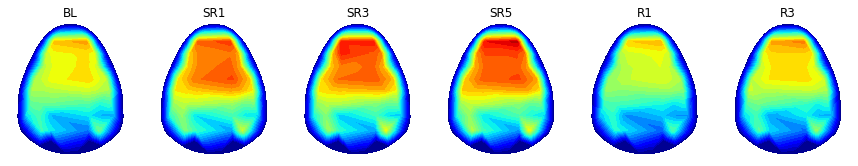

REM theta


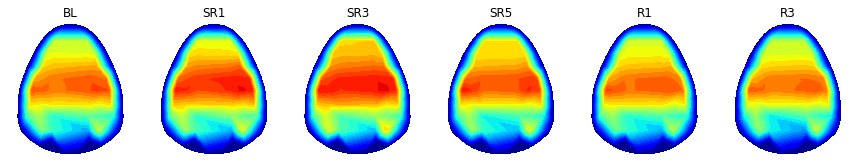

In [219]:
# Topography visualization loop: with [topos] matrix

# Outlier elimination
topos_to_draw = topos.copy()
topos_to_draw[:,:,1,8,0,0]= np.nan; # Bad data

print('NREM delta')
clim = (0,9)
plt.figure(figsize=(15,8))
counter = 1
for dayIdx in range(9):
    n_valid_sample = 9-np.sum( np.isnan( np.nanmean(np.nanmean( topos_to_draw[:,:,dayIdx,:,0,1], 1 ), 0)))
    if n_valid_sample > 3: # Ignoring small samples
        plt.subplot(1,6,counter); counter += 1
        hdeeg_exist = np.mean( np.isnan(powers_to_draw) ) < 1
        xx,yy,topo = plot_topo2d( powers_to_draw, plot_opt = False )
        topo = np.nanmean( topos_to_draw[:,:,dayIdx,:,0,1], axis=2) 
        plt.contourf(xx, yy, topo, cmap=cm.jet, levels = np.linspace(clim[0],clim[1],30))
        plt.grid(False)
        plt.gca().set_aspect('equal','box')
        plt.axis( (-5.5, 5.5, -7, 5.2) ) 
        plt.gca().set_facecolor((1,1,1))
        plt.xticks([999],color='k'); plt.yticks([999],color='k')
        plt.clim(clim)
        title( '%s'%(condition_label[dayIdx]), fontsize=12)
plt.savefig( '%sFig_QQ_topo_NREMdelta.jpg'%(figure_directory), dpi=figure_dpi )
plt.show()

print('REM theta')
plt.figure(figsize=(15,8))
counter = 1
clim = (0,3.5)
for dayIdx in range(9):
    n_valid_sample = 9-np.sum( np.isnan( np.nanmean(np.nanmean( topos_to_draw[:,:,dayIdx,:,1,2], 1 ), 0)))
    if n_valid_sample > 3: # Ignoring small samples
        plt.subplot(1,6,counter); counter += 1
        hdeeg_exist = np.mean( np.isnan(powers_to_draw) ) < 1
        xx,yy,topo = plot_topo2d( powers_to_draw, plot_opt = False )
        topo = np.nanmean( topos_to_draw[:,:,dayIdx,:,1,2], axis=2) 
        plt.contourf(xx, yy, topo, cmap=cm.jet, levels = np.linspace(clim[0],clim[1],30))
        plt.grid(False)
        plt.gca().set_aspect('equal','box')
        plt.axis( (-5.5, 5.5, -7, 5.2) ) 
        plt.gca().set_facecolor((1,1,1))
        plt.xticks([999],color='k'); plt.yticks([999],color='k')
        plt.clim(clim)
        title( '%s'%(condition_label[dayIdx]), fontsize=12)
plt.savefig( '%sFig_QQ_topo_REMtheta.jpg'%(figure_directory), dpi=figure_dpi )
plt.show()
        

Now, do it on your own!